### Topic modeling with NMF and LDA

1. Load dataframe of neighborhoods and extract neighborhood descriptions (lemmas)
2. Create vector, run NMF, assign topic distributions to each listing, and pickle results using:
    * NMF
    * LDA
4. Visualize topics LDA topics with pyLDAvis
5. Complete LDA with gensim

Resources:
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py)
* [Practical Topic Finding for Short-Sentence Texts](http://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb)
* [Topic Modeling with Scikit Learn](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730#.gabw32h5e)
* [Improving the Interpretation of Topic Models](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d#.8j9ngyi91)
* [Care and Feeding of Topic Models: Problems, Diagnostics, and Improvements](https://mimno.infosci.cornell.edu/papers/2014_book_chapter_care_and_feeding.pdf)
* [Getting started with Latent Dirichlet Allocation in Python](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [Exporting Python Data to GeoJSON](http://geoffboeing.com/2015/10/exporting-python-data-geojson/)

In [1]:
import pickle

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation

import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#function to display top words within each topic
def display_topics(model, W, features, n):
    best_hosts = []
    for index, topic in enumerate(model.components_):
        print 'Topic %d:' % index
        print 'TOP %d WORDS:' % n
        for i in topic.argsort()[:-n - 1:-1]:
            print features[i]
        print 'REPRESENTATIVE HOST:'
        ind = np.argsort(W[:,index])[::-1][0]
        best_hosts.append(ind)
        print df_neighborhoods.iloc[ind][['neighborhood', 'city', 'state']]
        print
    return best_hosts

In [3]:
#parameters for topic models
num_topics = 8
num_top_words = 15

#### Load AirBnB neighborhoods dataframe and extract preprocessed neighborhood descriptions

In [4]:
with open('../data/interim/04_neighborhoods_lemmas.pkl', 'rb') as picklefile:
    df_neighborhoods = pickle.load(picklefile)

In [5]:
lemmas = df_neighborhoods['lemmas']

In [6]:
neighborhoods = df_neighborhoods['neighborhood'].tolist()
cities = df_neighborhoods['city'].tolist()
states = df_neighborhoods['state'].tolist()
loc = zip(neighborhoods, cities, states)

### NMF (sklearn)

#### Create TFIDF vector using neighborhood descriptions

In [7]:
nmf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.75,
                                 min_df=10)
                                 #max_features = 1000)

tfidf = nmf_vectorizer.fit_transform(lemmas)
nmf_features = nmf_vectorizer.get_feature_names()
len(nmf_features)

13393

In [8]:
#10 words with highest tfidf
top = nmf_vectorizer.idf_.argsort()[:100].tolist()
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in top]

[(u'include', 1.2936522394382846),
 (u'friendly', 1.2936522394382846),
 (u'love', 1.2951503670593068),
 (u'bus', 1.2981533723190763),
 (u'everything', 1.3102563944903198),
 (u'offer', 1.3194307707663613),
 (u'ride', 1.3194307707663613),
 (u'enjoy', 1.3333521092849692),
 (u'go', 1.360188763238529),
 (u'residential', 1.3617900446055029),
 (u'coffee shop', 1.365000320235751),
 (u'public', 1.365000320235751),
 (u'find', 1.3682209349357932),
 (u'see', 1.3943662150401155),
 (u'bike', 1.4060232995823283),
 (u'easy access', 1.4178178760751654),
 (u'people', 1.4195142293233438),
 (u'cafe', 1.4212134650763035),
 (u'night', 1.4280394301467034),
 (u'feel', 1.4280394301467034),
 (u'make', 1.4366379354019352),
 (u'nice', 1.440098146466831),
 (u'neighbor', 1.445311016655364),
 (u'day', 1.4505512033189203),
 (u'apartment', 1.4540599788485995),
 (u'convenient', 1.4593463347717475),
 (u'less', 1.4593463347717475),
 (u'several', 1.4611146818284895),
 (u'art', 1.4771721187243481),
 (u'know', 1.47897229922

In [9]:
#10 words with lowest tfidf
bottom = nmf_vectorizer.idf_.argsort()[::-1].tolist()[:20]
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in bottom]

[(u'homegrown', 5.4000451401765597),
 (u'day parade', 5.4000451401765597),
 (u'laundromat coffee', 5.4000451401765597),
 (u'show time', 5.4000451401765597),
 (u'day safe', 5.4000451401765597),
 (u'truly everything', 5.4000451401765597),
 (u'truly feel', 5.4000451401765597),
 (u'day residential', 5.4000451401765597),
 (u'fun live', 5.4000451401765597),
 (u'latin flavor', 5.4000451401765597),
 (u'day peaceful', 5.4000451401765597),
 (u'music day', 5.4000451401765597),
 (u'music gallery', 5.4000451401765597),
 (u'day head', 5.4000451401765597),
 (u'day find', 5.4000451401765597),
 (u'day favorite', 5.4000451401765597),
 (u'day evening', 5.4000451401765597),
 (u'day dont', 5.4000451401765597),
 (u'day bar', 5.4000451401765597),
 (u'music easy', 5.4000451401765597)]

#### Extract topics using NMF on TFIDF vector of host descriptions
* Number of components set to number of topics
* init set to Nonnegative Double Singular Value Decomposition (nndsvd), which is better for sparse matrices
* solver set to cd (recommended in documentation)

In [10]:
nmf = NMF(n_components=num_topics,
          init='nndsvd',
          solver = 'cd',
          random_state=16)
nmf_doc_topic = nmf.fit_transform(tfidf)
nmf_doc_topic.shape

(895, 8)

In [11]:
nmf_doc_topic_norm = nmf_doc_topic/np.sum(nmf_doc_topic, axis=1, keepdims=True)

In [12]:
sum(nmf_doc_topic_norm[1])

1.0

In [13]:
nmf_topic_word = nmf.components_
nmf_topic_word.shape

(8, 13393)

In [14]:
best_nmf_hosts = display_topics(nmf, nmf_doc_topic, nmf_features, num_top_words)

Topic 0:
TOP 15 WORDS:
music
art
coffee shop
venue
hip
cafe
taco
bike
gallery
eclectic
favorite
spot
cool
love
music venue
REPRESENTATIVE HOST:
neighborhood    Bouldin
city             austin
state                TX
Name: 130, dtype: object

Topic 1:
TOP 15 WORDS:
train
subway
supermarket
diverse
apartment
time
museum
pharmacy
bus
stop
residential
people
laundromat
botanical
bank
REPRESENTATIVE HOST:
neighborhood    Washington Heights
city                   newyorkcity
state                           NY
Name: 1598, dtype: object

Topic 2:
TOP 15 WORDS:
freeway
trader
trader joes
joes
movie
ralphs
hike
farmer
centrally
major
friendly
residential
whole food
neighbor
airport
REPRESENTATIVE HOST:
neighborhood    Sherman Oaks
city              losangeles
state                     CA
Name: 1351, dtype: object

Topic 3:
TOP 15 WORDS:
apartment
building
step
subway
boutique
famous
nightlife
whole food
whole
everything
low
time
cafe
attraction
gallery
REPRESENTATIVE HOST:
neighborhood    Greenw

#### A couple visualizations!

In [15]:
len(nmf_topic_word[0])

13393

In [16]:
nmf_topics = range(num_topics)

In [17]:
#plot importance of each word for each topic (1 plot per topic)
def plot_word_prob(topics, topic_word):
    f, ax= plt.subplots(len(topics), 1, figsize=(8, 24), sharex=True)
    x_min = -50
    x_max = len(topic_word[0]) + 50
    y_min = 0
    
    for i, k in enumerate(topics):
        y_max = round(max(topic_word[i])*1.1, 1)
        ax[i].stem(topic_word[i], linefmt='b-', markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("topic {}".format(k))

    plt.tight_layout()
    plt.show()

In [18]:
round(max(nmf_topic_word.flatten())*1.1, 1)

1.0

KeyboardInterrupt: 

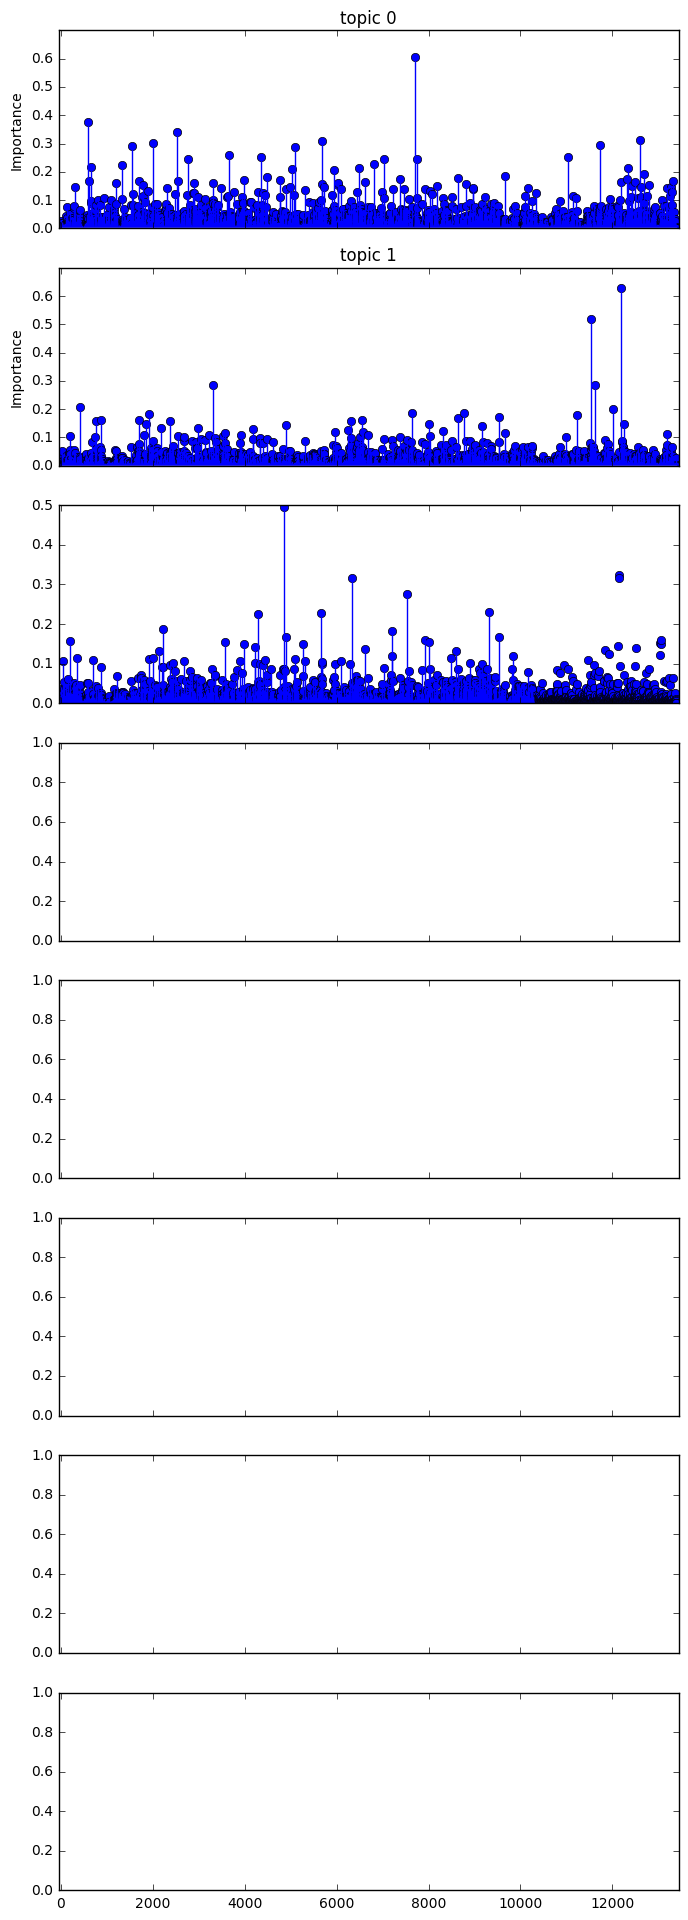

In [19]:
plot_word_prob(nmf_topics, nmf_topic_word)

In [20]:
#plot importance of all topics for document most representative of each topic (1 plot per topic)
def plot_doc_prob(best_hosts, doc_topic):
    f, ax= plt.subplots(len(best_hosts), 1, figsize=(8, 24), sharex=True)
    x_min = -1
    x_max = len(best_hosts)
    y_min = 0
    y_max = max(1, round(max(doc_topic.flatten())*1.1, 1))
    
    for i, k in enumerate(best_hosts):
        ax[i].stem(doc_topic[k], linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("Document {}".format(k))

    plt.tight_layout()
    plt.show()

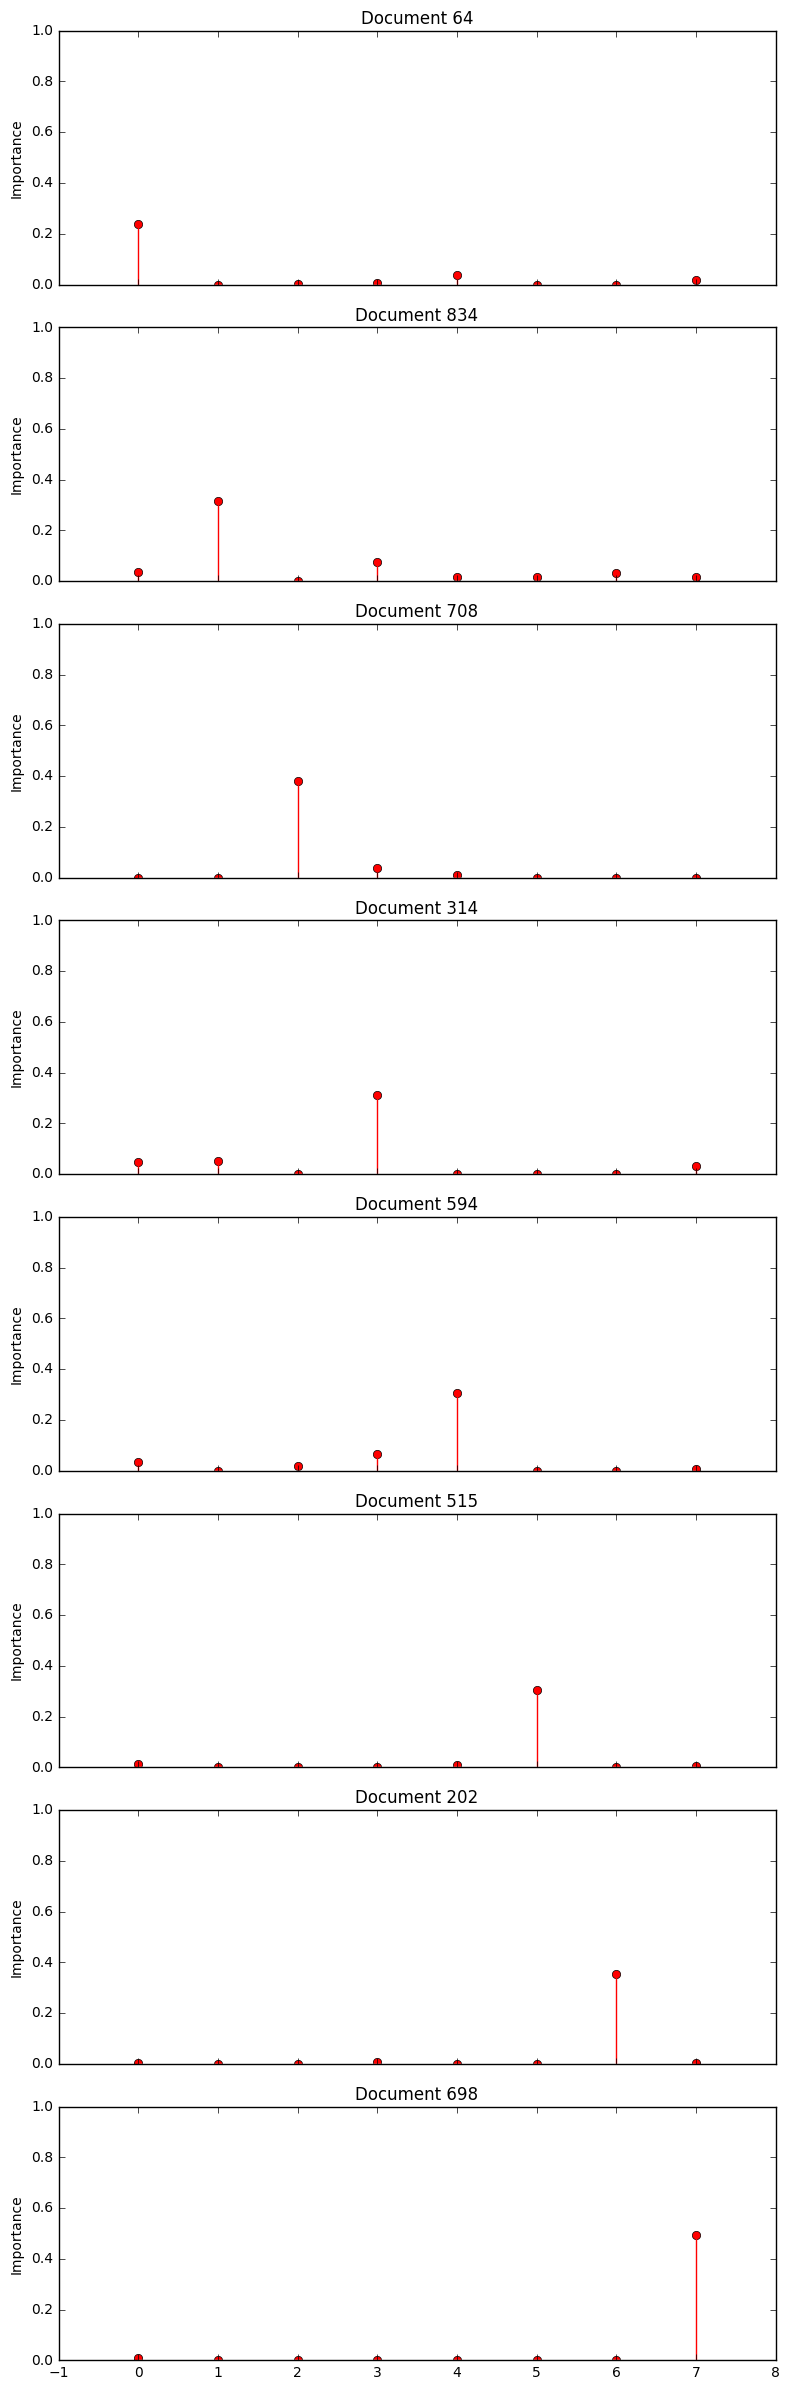

In [21]:
plot_doc_prob(best_nmf_hosts, nmf_doc_topic)

#### Visualizations for presenting

In [ ]:
import seaborn as sns
sns.set_style('white')

In [ ]:
viz_topics = {0: 1, 1: 4}

In [ ]:
def plot_for_viz(index, topic, topic_word, features):
    #print features[topic_word[index].argmax()[:3]]
    
    f, ax= plt.subplots(1, 1, figsize=(8, 2), sharex=True)
    x_min = -10
    x_max = len(topic_word[0])+10
    y_min = 0
    y_max = round(max(topic_word[index])*1.1, 1)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    markerline, stemlines, baseline = ax.stem(topic_word[index]) #, linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(markerline, 'color', '#595959')
    plt.setp(stemlines, 'color', '#595959')
    plt.setp(baseline, 'color', '#595959')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_for_viz(4, 'outdoorsy', nmf_topic_word, nmf_features)

In [ ]:
plot_for_viz(1, 'professional', nmf_topic_word, nmf_features)

#### Assign topic distribution to each listing

#### Pickle nmf topics dataframe

### LDA (sklearn)

#### Create term frequency vector using host descriptions (stopwords removed)

In [19]:
lda_vectorizer = CountVectorizer(#strip_accents = 'unicode',
                                #stop_words = 'english',
                                #lowercase = True,
                                #token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_features = 500,
                                ngram_range=(1,2),
                                max_df = 0.5, 
                                min_df = 20)
counts = lda_vectorizer.fit_transform(lemmas)
lda_features = lda_vectorizer.get_feature_names()
len(lda_features)

500

#### Extract topics using LDA on counts vector of host descriptions
* Number of components set to number of topics
* Learning method set to online for better performance

In [20]:
lda = LatentDirichletAllocation(n_topics=num_topics,
                                learning_method='online',
                                random_state=16)
lda_doc_topic = lda.fit_transform(counts)

In [21]:
lda_topic_word = lda.components_

In [22]:
best_lda_hosts = display_topics(lda, lda_doc_topic, lda_features, num_top_words)

Topic 0:
TOP 15 WORDS:
farmer
brewery
walkable
bakery
pizza
hike
boutique
ice
urban
beer
cream
ice cream
pub
yoga
wine
REPRESENTATIVE HOST:
neighborhood    Sellwood-Moreland
city                     portland
state                          OR
Name: 1333, dtype: object

Topic 1:
TOP 15 WORDS:
gallery
hip
cool
artist
train
venue
trendy
nightlife
vibrant
young
ave
music venue
hipster
culture
vintage
REPRESENTATIVE HOST:
neighborhood       Bushwick
city            newyorkcity
state                    NY
Name: 182, dtype: object

Topic 2:
TOP 15 WORDS:
train
diverse
subway
botanical
ave
library
brownstone
building
culture
eastern
caribbean
supermarket
treelined
zoo
mix
REPRESENTATIVE HOST:
neighborhood    Englewood
city              chicago
state                  IL
Name: 459, dtype: object

Topic 3:
TOP 15 WORDS:
gallery
low
art gallery
live music
jazz
venue
convention
festival
lady
look
eclectic
music venue
step
check
canal
REPRESENTATIVE HOST:
neighborhood    Treme' Lafitte
city          

#### Visualizations

In [ ]:
lda_topics = range(num_topics)

In [ ]:
lda_topic_word_norm = lda_topic_word/np.sum(lda_topic_word, axis=1, keepdims=True)

In [ ]:
round(max(lda_topic_word.flatten())*1.1, -1)

In [ ]:
plot_word_prob(lda_topics, lda_topic_word)

In [ ]:
plot_doc_prob(best_lda_hosts, lda_doc_topic)

#### Visualizations for presenting

In [ ]:
plot_for_viz(9, 'outdoorsy', lda_topic_word, lda_features)

In [ ]:
plot_for_viz(10, 'professional', lda_topic_word, lda_features)

#### Assign topic distribution to each listing

In [ ]:
lda_topics = pd.DataFrame(lda_doc_topic, columns=lda_topics)

In [ ]:
lda_topics.head()

#### Pickle lda topics dataframe

In [ ]:
with open('../data/interim/lda_topics.pkl', 'wb') as picklefile:
    pickle.dump(lda_topics, picklefile)